In [13]:
import numpy as np
from hankel_dmd import *
from numerical_solvers_and_models import *
from rbf_methods import *
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from save import *
from tabulate import tabulate
%matplotlib inline

## Numerically Computing Lyupanov Exponents for a Known Dynamical System

For a given dynamical system in $\mathbb{R}^{n}$, say 

$$
\frac{d}{dt}{\bf y} = f({\bf y}), ~ {\bf y}(0) = {\bf x} \in \mathbb{R}^{n},
$$

we denote its affiliated flow map via the function $\varphi_{t}({\bf x})$ so that ${\bf y}(t;{\bf x}) = \varphi_{t}({\bf x})$.  We call $f({\bf y})$ the *velocity field* of the flow.  We define the *Lyupanov exponents* (LEs)

For the solution ${\bf y}(t;{\bf x})$, we can compute the affiliated Jacobian $J(t)$ where
$$
J(t) = D_{{\bf y}}f\left({\bf y}(t;{\bf x})\right).
$$
This then defines the affiliated time-dependent linear system 
$$
\frac{d{\bf U}}{dt} = J(t){\bf U}, ~ {\bf U}(0) = {\bf I}.
$$
We then define the LEs to be the eigenvalues of the matrix $\Lambda$ where
$$
\Lambda = \lim_{t\rightarrow \infty} \frac{1}{2t}\log {\bf U}(t){\bf U}^{T}(t).
$$
Those eigenvalues of $\Lambda$ which are positive indicate sensitivity to initial conditions, and thus are indicators of chaotic behavior.  However, one can also have nonpositive Lyupanov exponents indicating directions of neutral or even contractive growth.  

While analytic computations are typically intractable, numerical schemes for computing LEs exists.  Using a discretized approximation to the solution of the original Lorenz system defined at discrete times $\left\{t_{j}\right\}_{j=0}^{N_{T}}$ where $t_{0}=0$ and $t_{j} = j\delta t$, to generate an approximation to the Lyupanov exponents, we solve for $t_{j}\leq t \leq t_{j+1}$: 
$$
\frac{d}{dt}{\bf U}_{j} = J(t){\bf U}_{j}, ~ {\bf U}_{j}(t_{j}) = {\bf Q}_{j}
$$
where ${\bf Q}_{0}={\bf I}$ and we perform a QR-decomposition such that 
$$
{\bf U}_{j}(t_{j+1}) = {\bf Q}_{j+1}{\bf R}_{j+1}
$$

From time step to time step, we have the analytic formula for the matrices ${\bf U}_{j}$
$$
{\bf U}_{j}(t_{j+1}) = {\bf Q}_{j} + \int_{t_{j}}^{t_{j+1}}{\bf J}(t){\bf U}_{j}(t)dt
$$
To get a stable approximation scheme, we can use a Trapezoid approximation to the integral so that
$$
\left({\bf I} - \frac{\delta t}{2} {\bf J}_{j+1} \right){\bf U}_{j}(t_{j+1}) = \left({\bf I} + \frac{\delta t}{2} {\bf J}_{j} \right){\bf Q}_{j}, 
$$
where ${\bf J}_{j} = {\bf J}(t_{j})$ and so forth.  Then the $m^{th}$ Lyupanov exponent $\lambda_{m}$ is found from the formula 
$$
\lambda_{m} = \lim_{j\rightarrow \infty}\frac{1}{t_{j}}\sum_{k=1}^{j}\log  \left|({\bf R}_{k})_{mm} \right|
$$
For further details on the theory here, see **Dieci et al, On the Computation of Lyapunov Exponents for Continuous Dynamical Systems, SIAM J. Num. Analysis, 34, 402-423, 1997**.

## Computing Lyupanov Exponents from Data Alone

Now to get estimates of Lyupanov exponents from just data alone, we need estimates of Jacobians of maps we otherwise do not have access to.  In Abarbanel et al, this is dealt with via least-squares fitting to Taylor series expansions.  Aside from being algorithmically unweildy, the accuracy of Taylor series expansions rely on proximity arguments we cannot guarantee to hold.  Thus, we propose instead to use Radial Basis Functions (RBFs) to do scattered interpolation to generate analytic non-local (or global) approximations to the map at each time step using nearest-neighbors to a given point ${\bf y}(t_{j})\equiv {\bf y}_{j}$.  

That all said, to begin our algorithm, we follow Abarbanel by 

1. Using a KD-tree algorithm, we find some number of nearest neighbors, say $N_{nb}$, to the point at which we wish to approximate ${\bf y}(t_{j})$.  We label the $l^{th}$ nearest neighbor of ${\bf y}_{j}$ as ${\bf y}^{(n)}_{l,j}$.  Note, while geometrically close to ${\bf y}_{j}$, the point ${\bf y}^{(n)}_{l,j}$ could correspond to a markedly different time $t_{k}$.  We denote the set of points ${\bf y}_{j} \cup \left\{{\bf y}^{(n)}_{l,j}\right\}_{l=1}^{N_{nb}}$ as $\mathcal{I}_{j}$.

2. Having found our nearest-neighbors, we follow each point one time step, $\delta t$, forward in time.  This generates the points ${\bf y}_{j+1}$ as well as ${\bf y}^{(n),+}_{l,j} = \varphi_{\delta t}\left({\bf y}^{(n)}_{l,j}\right)$ and ${\bf y}^{(n),-}_{l,j} = \varphi_{-\delta t}\left({\bf y}^{(n)}_{l,j}\right)$.   

3. We then can approximate the unknown function $f({\bf y})$ using second-order centered-finite differencing via the formulas 
$$
f_{j} = \frac{{\bf y}_{j+1}-{\bf y}_{j-1}}{2\delta t}, ~ f^{(n)}_{l,j} = \frac{{\bf y}^{(n),+}_{l,j}-{\bf y}^{(n),-}_{l,j}}{2\delta t}
$$

4. We now depart from the approach of Abarbanel et al and use RBFs to build an interpolatory approximation for the points $\left( {\bf y}_{j}, f_{j} \right)$ and $\left\{ \left( {\bf y}^{(n)}_{l,j} ,f^{(n)}_{l,j}\right)\right\}_{l=1}^{N_{nb}}$.  Using this, we can then readily differentiate to find approximations to $J(t_{j})$.  

We see that while this approach is intuitively appealing, our reliance on centered differences to approximate the velocity field $f({\bf y})$ will cost us in terms of accuracy when velocities in the flow, i.e. $\dot{{\bf y}}$, are relatively high.  We should note then that any subsequent method applied to interpolate our data, such as RBFs or Taylor Series, cannot be blamed for fundamental innaccuracies introduced by our approximation to the velocity field.  This then provides the best explanation of errors we see in the following results.  A next approach for improvement is to use RBFs to approximate the flow map $\varphi_{t}({\bf x})$ directly, which will be the subject of future work.    

## The Role of Fill Distance in Understanding Attractor Shape

To understand the extent to which our scattered interpolation points $\mathcal{I}_{j}$,  fill a given region of space, say $\Omega_{j}$, one defines the *fill distance* $h_{j}$ to be 
$$
h_{j} = \sup_{\tilde{{\bf y}}\in \Omega_{j}}\min_{{\bf y} \in \mathcal{I}_{j}} \left|\left|\tilde{{\bf y}} - {\bf y}\right|\right|
$$
In our problems, we want to take $\Omega_{j}$ to be a subset of the attractors we are interested in approximating Jacobians on.  

To do this, we generate points $\tilde{{\bf y}}$ along trajectories of our dynamical system using a total run time given by $10 t_{f}$.  This should provide a denser filling of the attractor.  Thus by looking at the point ${\bf y}_{j}$ in both trajectories, we can look at how the set $\mathcal{I}_{j}$ fills local regions chosen off the more densely filled approximation to attractor.  For the more densely filled approximation to the attractor, we take $\Omega_{j}$ to consist of the $2 N_{nb}$ nearest neighbors of ${\bf y}_{j}$.   

## The Lorenz Equation

We now turn to one of the classics of dynamical systems, the Lorenz equations, which are given by the system

\begin{align}
\dot{y}_{1} = & -\sigma y_{1} + \sigma y_{2}\\
\dot{y}_{2} = & \rho y_{1} - y_{2} - y_{1}y_{3}\\
\dot{y}_{3} = & y_{1}y_{2}-by_{3}
\end{align}

In order to guarante that we have a strange attractor, we use the now standard parameter choice

$$
\rho = 28, \quad b = \frac{8}{3}, \quad \sigma = 10.
$$

We start from an initial condition of ${\bf x} = (0,1,0)$.  We numerically solve this on the time interval $0\leq t \leq 90$ using a fourth order Runge-Kutta scheme with a time step of $\delta t=.01$.  The affiliated Jacobian $J(t)$ is given by

$$
J(t) = \begin{pmatrix}
-\sigma & \sigma & 0 \\ \rho-y_{3}(t) & -1 & -y_{1}(t) \\ y_{2}(t) & y_{1}(t) & -b
\end{pmatrix}
$$

In [14]:
dt = .001
t0 = 0.
tf = 90.
tvals = np.linspace(t0,tf,int((tf-t0)/dt)+1)
x0 = np.array([0., 1., 0.])

In [15]:
sigma = 10.
rval = 28.
bval = 8./3.
fhandle = lambda x: lorenz(x,sigma,rval,bval)
rawdata_lorenz = timestepper(x0, t0, tf, dt, fhandle)
finedata_lorenz = timestepper(x0, t0, 10.*tf, dt, fhandle)

Name the file: Lorenz 90 0,001


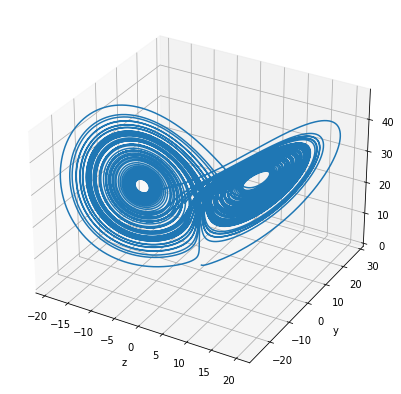

In [16]:
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Attractor Plots', '3D Plots')
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot3D(rawdata_lorenz[0,:], rawdata_lorenz[1,:], rawdata_lorenz[2,:])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlabel('z')
plot_name = input('Name the file: ')
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_attractor_3D, plot_name, '.png')
filepath = save_attractor_3D + plot_name
plt.savefig(filepath)
plt.show()

In [17]:
lorenz_lyu_vals = lorenz_lyupanov_solver(rawdata_lorenz, sigma, rval, bval, dt)
print(lorenz_lyu_vals)

[  0.71895058   0.03303332 -14.41849871]


In [128]:
# -------------------
# Save Dialog
# -------------------
data_name = input('Name entry: ')
#head = ['Attractor', 'lambda 1', 'lambda 2', 'lambda 3']
row = [data_name, lorenz_lyu_vals[0], lorenz_lyu_vals[1], lorenz_lyu_vals[2]]
#table = tabulate([head, row], headers='firstrow')
table = tabulate([row])
save_table = create_directory('Tables')
table_name = 'Deici Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + 'Deici Lyapunov exponents'
table_write = open(table_name + '.txt', 'a')
table_write.write(table)
table_write.close()
print('Comparison Lyapunov Exponents: \n', table)

Name entry: Lorenz, dt=0,001
A file of this name already exists! Do you want to rewrite it? [y/n]: y
Comparison Lyapunov Exponents: 
 ----------------  --------  ----------  --------
Lorenz, dt=0,001  0.891902  0.00378951  -14.5623
----------------  --------  ----------  --------


To generate our data driven approximations to the Lyupanov exponents of the Lorenz equations on the strange attractor, we start collecting data from $t\geq t_{i}$ where $t_{i}=50$.  This should ensure our numerically generated trajectory is on the attractor.  The choice of $t_{f}=90$ seems to ensure that the one trajectory we are using does a reasonably good job of filling out the attractor from just one trajectory, but one should try these experiments for larger values of $t_{f}$ to verify any results.  

In [18]:
ti = 10.
transient_skip = int(ti/dt) # set initial index to be at t=10. 
indstart = 2 # This is relative to transient_skip  
indfin = int((tf)/dt) - transient_skip
skip = int(.5/dt) # skip every 1 unit of time
inds = np.arange(indstart,indfin,skip)
skip_taxis = ti + inds*dt

# Exact Jacobian terms, so we can do error calculations.  
pjac_mat_exact = np.zeros((3, 3), dtype=np.float64)
pjac_mat_exact[0, 0] = -sigma
pjac_mat_exact[0, 1] = sigma
pjac_mat_exact[1, 1] = -1.
pjac_mat_exact[2, 2] = -bval

In [19]:
# compute nearest neighbors 
num_neighbors = 50
reddata = rawdata_lorenz[:,transient_skip:]
redfinedata = finedata_lorenz[:,transient_skip:]

# coarse nearest neighbors computation
nbrs = NearestNeighbors(n_neighbors=num_neighbors, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)

# finer nearest neighbors computation
finenbrs = NearestNeighbors(n_neighbors=2*num_neighbors, algorithm='kd_tree').fit(redfinedata.T)
finedistances, fineindices = finenbrs.kneighbors(redfinedata.T)

In [20]:
params = [rval, sigma, bval]
centered_diff_errors = np.zeros(np.size(inds))
mags = np.zeros(np.size(inds))
cnt = 0

for current_ind in inds:
    error, mag = centered_diff_test(reddata, indices, dt, current_ind, 'Lorenz', params)
    centered_diff_errors[cnt] = error
    mags[cnt] = mag
    cnt += 1

Name the file: 


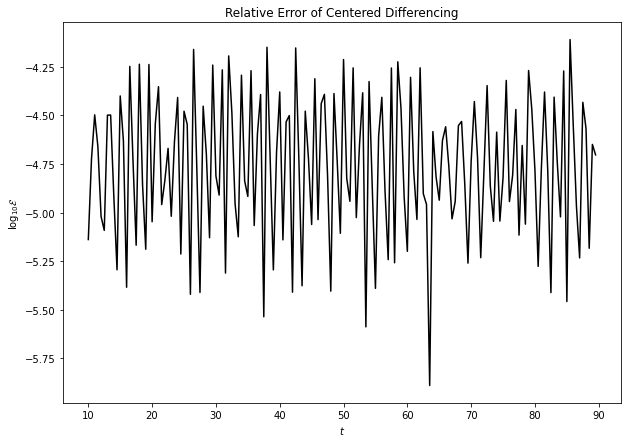

In [23]:
plt.figure(figsize=(10,7))
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Centered Differencing')
plt.plot(skip_taxis, np.ma.log10(centered_diff_errors), color='k')
plt.title("Relative Error of Centered Differencing")
plt.xlabel("$t$")
plt.ylabel("$\log_{10}\mathcal{E}$")
plot_name = input('Name the file: ')
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_attractor_3D, plot_name, '.png')
filepath = save_attractor_3D + plot_name
plt.savefig(filepath)
plt.show()

In [24]:
# plt.plot(skip_taxis, np.ma.log10(mags), color='k')

In [25]:
# tune for optimal epsilon using 'drop-one' algorithm
shandle='gaussian'
#shandle='multiquadric'
#shandle='inverse'

In [26]:
NTT = np.shape(reddata)[1]
jacerrors = np.zeros(np.size(inds))
shape_params = np.zeros(np.size(inds))
filldist = np.zeros(np.size(inds))
cnt = 0

for current_ind in inds:
    
    yloc = reddata[:,current_ind]
    nnindices = indices[current_ind]
    ipts = reddata[:,nnindices]
    epval = shape_parameter_tuner(ipts.T, shandle)
    shape_params[cnt] = epval 
    
    nnfineindices = fineindices[current_ind]
    fineipts = redfinedata[:,nnfineindices]    
    hfill = fill_distance_compute(ipts, fineipts)
    filldist[cnt] = hfill
        
    pjac_mat_exact[1, 0] = rval - yloc[2]
    pjac_mat_exact[1, 2] = -yloc[0]
    pjac_mat_exact[2, 0] = yloc[1]
    pjac_mat_exact[2, 1] = yloc[0]
    
    jacmat, condnumber = jacobian_maker(reddata, shandle, indices, dt, epval, current_ind)
    jacerrors[cnt] = np.linalg.norm(jacmat - pjac_mat_exact,ord='fro')/np.linalg.norm(pjac_mat_exact,ord='fro')
    
    cnt += 1

Name the file: 


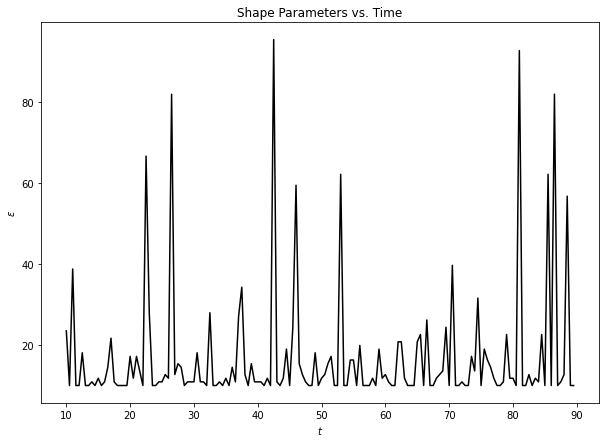

In [27]:
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Shape Parameter')
plt.figure(figsize=(10,7))
plt.plot(skip_taxis, shape_params, color='k')
plt.title("Shape Parameters vs. Time")
plt.xlabel(r"$t$")
plt.ylabel(r"$\epsilon$")
plot_name = input('Name the file: ')
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_attractor_3D, plot_name, '.png')
filepath = save_attractor_3D + plot_name
plt.savefig(filepath)
plt.show()

/var/folders/9x/kw_qbzfn1ng2b357bvzcw1zh0000gn/T/ipykernel_5847/745972912.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(skip_taxis, np.log10(filldist), color='g', label="Fill Distance")


Name the file: 


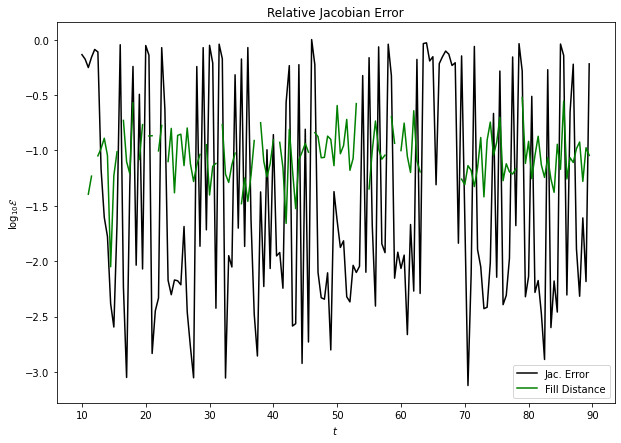

In [28]:
plt.figure(figsize=(10,7))
plt.plot(skip_taxis, np.log10(jacerrors), color='k', label="Jac. Error")
plt.plot(skip_taxis, np.log10(filldist), color='g', label="Fill Distance")
plt.xlabel(r"$t$")
plt.ylabel(r"$\log_{10}\mathcal{E}$")
plt.title("Relative Jacobian Error")
plt.legend()
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Jacobian Error')
plot_name = input('Name the file: ')
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_attractor_3D, plot_name, '.png')
filepath = save_attractor_3D + plot_name
plt.savefig(filepath)
plt.show()

As we see in the above figures, the shape parameter is wildly more responsive to moving along the trajectory (and thus the strange attractor) than the fill distance.  This in part then explains the ability of RBFs to adapt to changing conditions which keeps the overall relative error of the Jacobian approximations (measured in the Frobenius norm) relatively small aside from initial transients near the beginning of when we imagine that we are entrained to move stricly on the attractor.  

With this result, we see that RBFs have given us a reasonably straightforward and accurate means of approximating Jacobians along the flow.  We can now see how these approximations manifest in the approximations to the LEs.  

In [29]:
NTT = np.shape(reddata)[1]
qprior = np.eye(3,dtype=np.float64)
imat = np.eye(3,dtype=np.float64)
rvals = np.ones((3,NTT),dtype=np.float64)

for jj in range(NTT-1):
    
    jacmatn, cvaln = jacobian_maker(reddata, shandle, indices, dt, epval, jj)
    jacmatp, cvalp = jacobian_maker(reddata, shandle, indices, dt, epval, jj+1)
    
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat-dt/2*jacmatp),(imat+dt/2*jacmatn)@qprior))
    rvals[:,jj] = np.diag(rnext)
    
lvals = np.sum(np.log(np.abs(rvals)), 1)/tf

In [30]:
print(lvals)

[ 0.77624328 -0.02935479 -8.41688523]


In [31]:
# --------------------
# Save dialog
# --------------------
#head = ['RBF', 'time length', 'time step', 'neighbors,','lambda 1', 'lambda 2', 'lambda 3']
row = [shandle, str(tf), str(dt), str(num_neighbors),lvals[0], lvals[1], lvals[2]]
#table = tabulate([head, row], headers='firstrow')
table = tabulate([row])
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Lorenz')
table_name = 'RBF Estimated Lorenz 001 Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write(table)
table_write.close()
print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
--------  --  -----  --  --------  ----------  --------
gaussian  90  0.001  50  0.776243  -0.0293548  -8.41689
--------  --  -----  --  --------  ----------  --------


## The Rossler Equation

Just to get our feet wet and to build some more direct familiarity with Takens Embedding Theorem, we turn to one of the classics of dynamical systems, the Rossler equations, given by the system

\begin{align}
\dot{y}_{1} = & -y_{2} - y_{3}\\
\dot{y}_{2} = & y_{1} + ay_{2}\\
\dot{y}_{3} = & b + y_{3}(y_{1}-c)
\end{align}

Following the approach laid out in *Broomhead et al, Physica D, 217-236, 1986*, we use the parameter values

$$
a = .2, \quad b = .2, \quad c = 5.7
$$

starting from an initial condition of ${\bf x} = (0,1,0)$.  We numerically solve this on the time interval $0\leq t \leq 180$ using a fourth order Runge-Kutta scheme with a time step of $\delta t=.01$.  Note, the longer time scale is necessary in order to get a more robust filling of the Rossler attractor from just one initial condition.  The affiliated Jacobian is given by the formula

$$
J(t) = \begin{pmatrix}
0 & -1 & -1 \\ 1 & a & 0 \\ y_{3}(t) & 0 & y_{1}(t)-c
\end{pmatrix}
$$

In [32]:
tf = 180.
dt = .001
aval = .2
bval_rossler = .2
cval = 5.7
fhandle = lambda x: rossler(x,aval,bval_rossler,cval)
rawdata_rossler = timestepper(x0, t0, tf, dt, fhandle)
finedata_rossler = timestepper(x0, t0, 2.*tf, dt, fhandle)

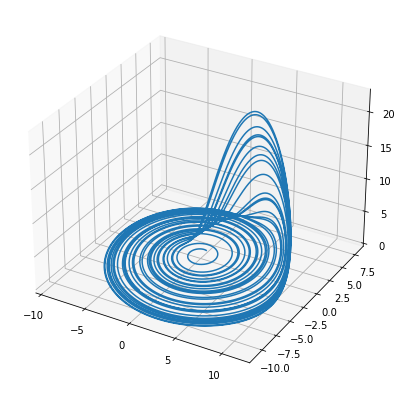

In [33]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot3D(rawdata_rossler[0,:], rawdata_rossler[1,:], rawdata_rossler[2,:])

In [167]:
rossler_lyu_vals = rossler_lyupanov_solver(rawdata_rossler, aval, cval, dt)
print(rossler_lyu_vals)

[ 7.23337818e-02  2.49076559e-03 -5.40338316e+00]


In [168]:
# -------------------
# Save Dialog
# -------------------
data_name = input('Name entry: ')
#head = ['Attractor', 'lambda 1', 'lambda 2', 'lambda 3']
row = [data_name, rossler_lyu_vals[0], rossler_lyu_vals[1], rossler_lyu_vals[2]]
#table = tabulate([head, row], headers='firstrow')
table = tabulate([row])
save_table = create_directory('Tables')
table_name = 'Deici Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + 'Deici Lyapunov exponents'
table_write = open(table_name + '.txt', 'a')
table_write.write(table)
table_write.close()
print('Comparison Lyapunov Exponents: \n', table)

Name entry: Rossler, dt=0,001
A file of this name already exists! Do you want to rewrite it? [y/n]: y
Comparison Lyapunov Exponents: 
 -----------------  ---------  ----------  --------
Rossler, dt=0,001  0.0723338  0.00249077  -5.40338
-----------------  ---------  ----------  --------


In [34]:
ti = 50.
transient_skip = int(ti/dt) # set initial index to be at t=10. 
indstart = 2 # This is relative to transient_skip  
indfin = int(tf/dt) - transient_skip
skip = int(.5/dt) # skip every 1 unit of time
inds = np.arange(indstart,indfin,skip)
skip_taxis = ti + inds*dt

# keep around for testing purposes
pjac_mat_exact = np.zeros((3, 3), dtype=np.float64)
pjac_mat_exact[0, 1] = -1.
pjac_mat_exact[0, 2] = -1.
pjac_mat_exact[1, 0] = 1.
pjac_mat_exact[1, 1] = aval

In [35]:
# compute nearest neighbors 
num_neighbors = 50
reddata = rawdata_rossler[:,transient_skip:]
redfinedata = finedata_rossler[:,transient_skip:]

# coarse nearest neighbors computation
nbrs = NearestNeighbors(n_neighbors=num_neighbors, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)

# finer nearest neighbors computation
finenbrs = NearestNeighbors(n_neighbors=2*num_neighbors, algorithm='kd_tree').fit(redfinedata.T)
finedistances, fineindices = finenbrs.kneighbors(redfinedata.T)

In [36]:
params = [aval, bval_rossler, cval]
centered_diff_errors = np.zeros(np.size(inds))
mags = np.zeros(np.size(inds))
cnt = 0

for current_ind in inds:
    error, mag = centered_diff_test(reddata, indices, dt, current_ind, 'Rossler', params)
    centered_diff_errors[cnt] = error
    mags[cnt] = mag
    
    cnt += 1

Name the file: Rossler, 0,005


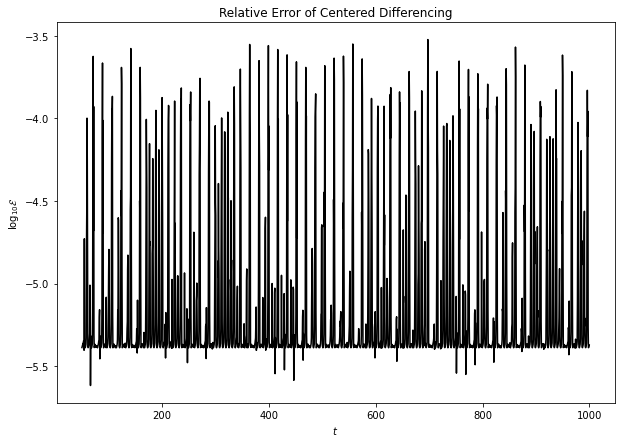

In [99]:
plt.figure(figsize=(10,7))
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Centered Differencing')
plt.plot(skip_taxis, np.ma.log10(centered_diff_errors), color='k')
plt.title("Relative Error of Centered Differencing")
plt.xlabel("$t$")
plt.ylabel("$\log_{10}\mathcal{E}$")
plot_name = input('Name the file: ')
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_attractor_3D, plot_name, '.png')
filepath = save_attractor_3D + plot_name
plt.savefig(filepath)
plt.show()

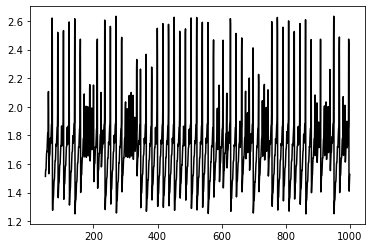

In [100]:
plt.plot(skip_taxis, np.ma.log10(mags), color='k')

In [37]:
# tune for optimal epsilon using 'drop-one' algorithm
shandle='gaussian'
#shandle='multiquadric'
#shandle='inverse'

In [38]:
NTT = np.shape(reddata)[1]
shape_params = np.zeros(np.size(inds))
jacerrors = np.zeros(np.size(inds))
filldist = np.zeros(np.size(inds))

cnt = 0
for current_ind in inds:
    
    yloc = reddata[:,current_ind]
    nnindices = indices[current_ind]
    ipts = reddata[:,nnindices]
    epval = shape_parameter_tuner(ipts.T, shandle)
    shape_params[cnt] = epval
    
    nnfineindices = fineindices[current_ind]
    fineipts = redfinedata[:,nnfineindices]    
    hfill = fill_distance_compute(ipts, fineipts)
    filldist[cnt] = hfill
        
    pjac_mat_exact[2, 0] = yloc[2]
    pjac_mat_exact[2, 2] = yloc[0]-cval
    
    jacmat, condnumber = jacobian_maker(reddata, shandle, indices, dt, epval, current_ind)
    
    jacerrors[cnt] = np.linalg.norm(jacmat - pjac_mat_exact,ord='fro')/np.linalg.norm(pjac_mat_exact,ord='fro')
    
    cnt += 1

Name the file: Rossler, 0,005


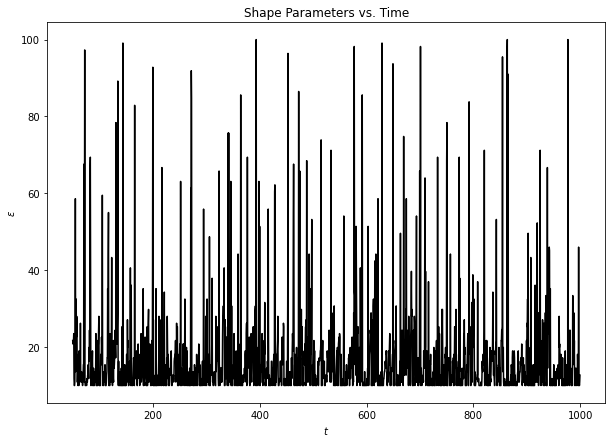

In [103]:
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Shape Parameter')
plt.figure(figsize=(10,7))
plt.plot(skip_taxis, shape_params, color='k')
plt.title("Shape Parameters vs. Time")
plt.xlabel(r"$t$")
plt.ylabel(r"$\epsilon$")
plot_name = input('Name the file: ')
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_attractor_3D, plot_name, '.png')
filepath = save_attractor_3D + plot_name
plt.savefig(filepath)
plt.show()

/var/folders/9x/kw_qbzfn1ng2b357bvzcw1zh0000gn/T/ipykernel_5847/745972912.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(skip_taxis, np.log10(filldist), color='g', label="Fill Distance")


Name the file: Rossler 90 0,001


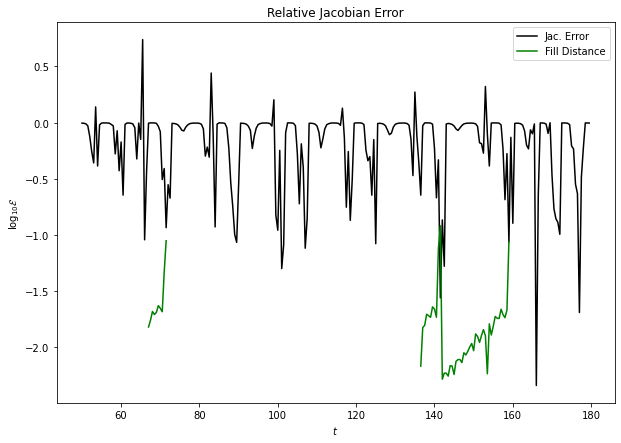

In [39]:
plt.figure(figsize=(10,7))
plt.plot(skip_taxis, np.log10(jacerrors), color='k', label="Jac. Error")
plt.plot(skip_taxis, np.log10(filldist), color='g', label="Fill Distance")
plt.xlabel(r"$t$")
plt.ylabel(r"$\log_{10}\mathcal{E}$")
plt.title("Relative Jacobian Error")
plt.legend()
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Jacobian Error')
plot_name = input('Name the file: ')
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_attractor_3D, plot_name, '.png')
filepath = save_attractor_3D + plot_name
plt.savefig(filepath)
plt.show()

We see a markedly different error profile for the Rossler attractor.  In this case, we see periodically recurring order one errors as well as strong, albeit rare, radical departures, in accuracy of the Jacobian approximation.  Regardless, none of this seems well correlated to the fill distance, and thus we imagine here that most of our problems stem from the centered difference approximation underlying our interpolation scheme.  We note that the Rossler attractor has strong temporal gradients due to almost nearly singular perturbative phenemona in the dynamics.  This is essentially the manifestation of stiffness in our algorithm, which in part will hopefully be ameliorated by a more sophisticated interpolation scheme.  This will be the subject of future work.   

We now go ahead and compute the affiliated Lyupanov exponents.  

In [40]:
NTT = np.shape(reddata)[1]
qprior = np.eye(3,dtype=np.float64)
imat = np.eye(3,dtype=np.float64)
rvals = np.ones((3,NTT),dtype=np.float64)

for jj in range(NTT-1):
    
    jacmatn, cvaln = jacobian_maker(reddata, shandle, indices, dt, epval, jj)
    jacmatp, cvalp = jacobian_maker(reddata, shandle, indices, dt, epval, jj+1)
    
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat-dt/2*jacmatp),(imat+dt/2*jacmatn)@qprior))
    rvals[:,jj] = np.diag(rnext)
    
lvals = np.sum(np.log(np.abs(rvals)), 1)/tf

In [41]:
print(lvals)

[ 0.02904892  0.0011676  -0.22842311]


In [42]:
# --------------------
# Save dialog
# --------------------
head = ['RBF', 'time length', 'time step', 'neighbors,','lambda 1', 'lambda 2', 'lambda 3']
row = [shandle, str(tf), str(dt), str(num_neighbors),lvals[0], lvals[1], lvals[2]]
table = tabulate([head, row], headers='firstrow')
#table = tabulate([row])
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Rossler')
table_name = 'RBF Estimated Rossler 001 Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write(table)
table_write.close()
print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
RBF         time length    time step    neighbors,    lambda 1    lambda 2    lambda 3
--------  -------------  -----------  ------------  ----------  ----------  ----------
gaussian            180        0.001            50   0.0290489   0.0011676   -0.228423
